#              VISUALISING YOUTUBE TRENDING VIDEO STATISTICS

In [2]:
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
nltk.download('stopwords')

/Users/aarthi/libpff/anaconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aarthi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
input_statistics = [i for i in glob.glob('youtube-new/*.{}'.format('csv'))]
sorted(input_statistics)

['youtube-new/CAvideos.csv',
 'youtube-new/DEvideos.csv',
 'youtube-new/FRvideos.csv',
 'youtube-new/GBvideos.csv',
 'youtube-new/USvideos.csv']

In [4]:
dfs_list = list()
for csv in input_statistics:
    df = pd.read_csv(csv, index_col='video_id',encoding = "ISO-8859-1")
    df['country'] = csv[12:14]
    dfs_list.append(df)

consolidated_df = pd.concat(dfs_list)
consolidated_df.head(3)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
video_id,,,,,,,,,,,,,,,,
LgVi6y5QIjM,17.14.11,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,inscope21,24,2017-11-13T17:08:49.000Z,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",252786,35885,230,1539.0,https://i.ytimg.com/vi/LgVi6y5QIjM/default.jpg,False,False,False,Heute gibt es mal wieder ein neues Format... w...,DE
Bayt7uQith4,17.14.11,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,LUKE! Die Woche und ich,23,2017-11-12T22:30:01.000Z,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",797196,53576,302,1278.0,https://i.ytimg.com/vi/Bayt7uQith4/default.jpg,False,False,False,Kinder ferngesteuert! Kinder lassen sich sooo ...,DE
1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97190,6146,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",DE


In [5]:
consolidated_df['trending_date'] = pd.to_datetime(consolidated_df['trending_date'],errors='coerce', format='%y.%d.%m')
consolidated_df['publish_time'] = pd.to_datetime(consolidated_df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

consolidated_df = consolidated_df[consolidated_df['trending_date'].notnull()]
consolidated_df = consolidated_df[consolidated_df['publish_time'].notnull()]

consolidated_df = consolidated_df.dropna(how='any',inplace=False, axis = 0)

consolidated_df.insert(4, 'publish_date', consolidated_df['publish_time'].dt.date)
consolidated_df['publish_time'] = consolidated_df['publish_time'].dt.time

consolidated_df_full = consolidated_df.reset_index().sort_values('trending_date').set_index('video_id')
consolidated_df = consolidated_df.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='last').set_index('video_id')
consolidated_df[['publish_date','publish_time']].head()

,publish_date,publish_time
video_id,,
IVRVXYCrr14,2017-11-05,18:00:01
1eS_17CG9sk,2017-11-05,12:03:04
NWdc7PyZNLA,2017-11-03,09:00:01
CCPX4EYrskw,2017-11-06,09:00:02
hIwRdDcQBEU,2017-11-06,16:33:36


In [6]:
consolidated_df.to_csv("newDataSet.csv")

In [7]:
consolidated_df['category_id'] = consolidated_df['category_id'].astype(str)
consolidated_df_full['category_id'] = consolidated_df['category_id'].astype(str)

category_id = {}

with open('youtube-new/US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        category_id[category['id']] = category['snippet']['title']

consolidated_df.insert(4, 'category', consolidated_df['category_id'].map(category_id))
consolidated_df_full.insert(4, 'category', consolidated_df_full['category_id'].map(category_id))
category_list = consolidated_df['category'].unique()
category_list

array(['People & Blogs', 'Comedy', 'Entertainment', 'Howto & Style',
       'Music', 'Film & Animation', 'Sports', 'News & Politics', 'Gaming',
       'Travel & Events', 'Autos & Vehicles', 'Science & Technology',
       'Education', 'Pets & Animals', 'Shows', 'Nonprofits & Activism',
       'Trailers'], dtype=object)

In [8]:
final_df = pd.DataFrame(consolidated_df_full.groupby([consolidated_df_full.index,'country']).count()['title'].sort_values(ascending=False)).reset_index()
final_df.head(), final_df.tail()

(  video_id country  title
 0   #NAME?      FR    365
 1   #NAME?      CA    355
 2   #NAME?      DE    353
 3   #NAME?      US    279
 4   #NAME?      GB    232,           video_id country  title
 62331  RfA2wAx6fA0      FR      1
 62332  mnDwhOQW5iI      CA      1
 62333  Rf2XBw_0Hco      DE      1
 62334  RepO6kFygzs      FR      1
 62335  zzz0_5fMnI8      FR      1)

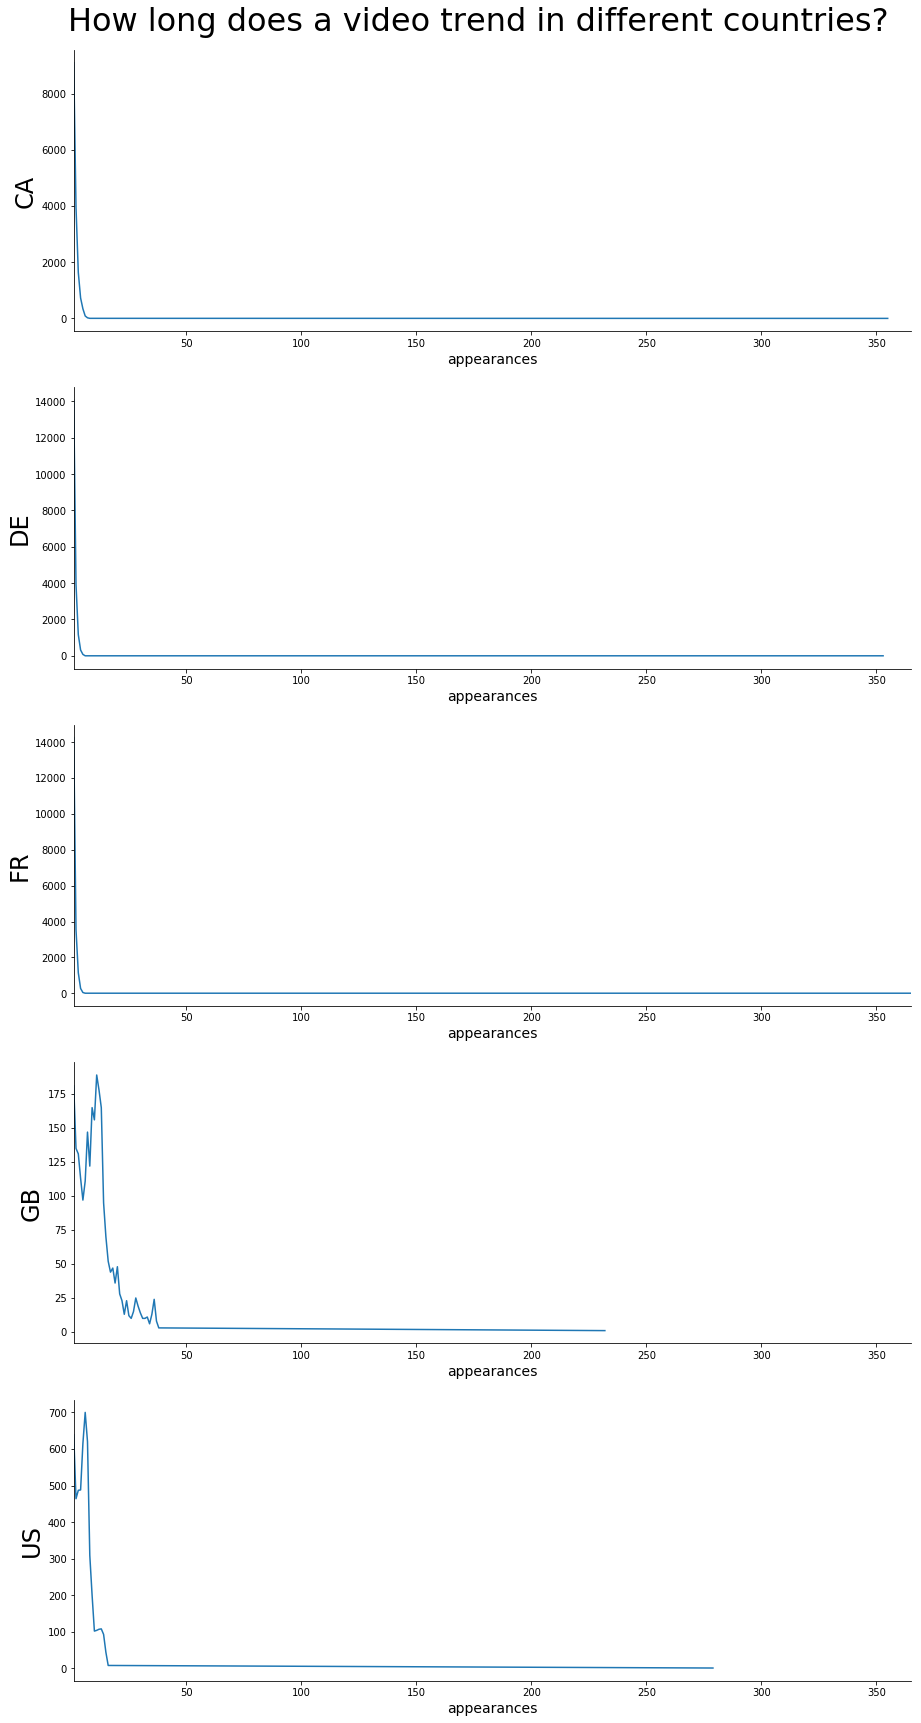

In [9]:
video_list,max_list = list(),list()
country_list = consolidated_df.groupby(['country']).count().index

for c in country_list:
    video_list.append(final_df[final_df['country']==c]['title'].value_counts().sort_index())
    max_list.append(max(final_df[final_df['country']==c]['title'].value_counts().sort_index().index))

fig, [ax0, ax1, ax2, ax3, ax4] = plt.subplots(nrows=5,figsize=(15, 30))
st = fig.suptitle("How long does a video trend in different countries?", fontsize=32)
st.set_y(0.9)
for i, pt in enumerate([ax0, ax1, ax2, ax3, ax4]):
    pt.plot(video_list[i].index, video_list[i])
    pt.spines['right'].set_visible(False)
    pt.spines['top'].set_visible(False)
    pt.set_xlabel("appearances",fontsize=14)
    pt.set_ylabel(country_list[i],fontsize=24)
    pt.axes.set_xlim(1, max(max_list))

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0)

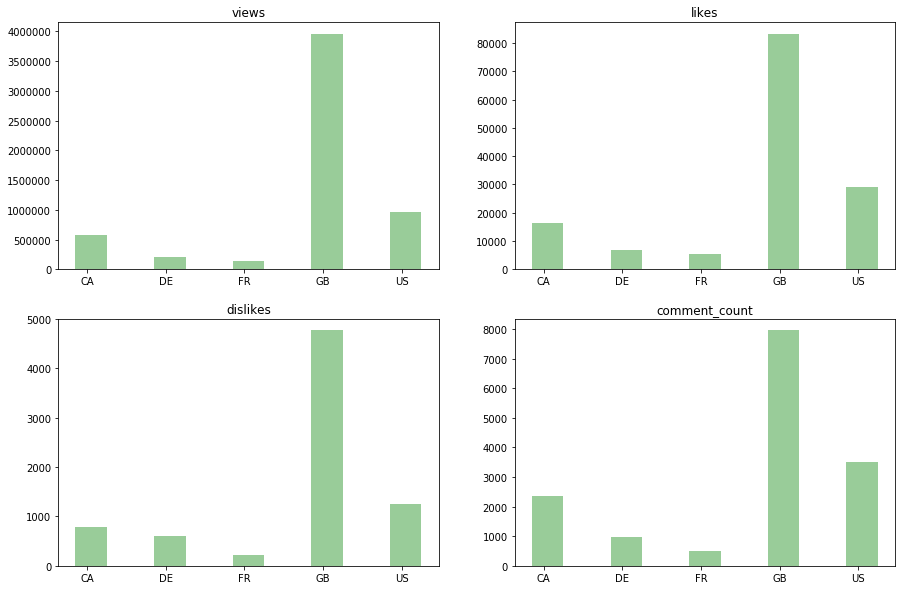

In [14]:
to_int = ['views', 'likes', 'dislikes', 'comment_count']
for column in to_int:
    consolidated_df[column] = consolidated_df[column].astype(int)
    
measures = list()
n_groups = len(country_list)
for i, typ in enumerate(to_int):
    measure = list()
    for c in country_list:
        measure.append(consolidated_df[consolidated_df['country']==c][typ].agg('sum')/len(consolidated_df[consolidated_df['country']==c].index.unique()))
    measures.append(measure)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2,nrows=2, figsize=(15,10))

index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.4
error_config = {'ecolor': '0.3'}

for i, axs in enumerate([[ax1, ax2], [ax3, ax4]]):
    for j, ax in enumerate(axs):
        ax.bar(index + (bar_width), measures[(i+j)+i], bar_width*4,
                alpha=opacity, color=['g','g','g','g','g'],
                error_kw=error_config)
        ax.set_title(to_int[(i+j)+i])
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(country_list)

In [13]:
corr_list = pd.DataFrame(final_df['video_id'].unique(), columns=['video_id'])
for country_code in final_df['country'].unique():
    corr_list[country_code] = 0
corr_list['total']=0
corr_list=corr_list.set_index('video_id')
for index , item in corr_list.iterrows():
    total = 0
    for i ,row in final_df[final_df['video_id'] == index][['country','title']].iterrows():
        total += row['title']
        corr_list.loc[[index],[row['country']]] = row['title']
    corr_list.loc[[index],['total']] = total
corr_list.head()

,FR,CA,DE,US,GB,total
video_id,,,,,,
#NAME?,365,355,353,279,232,1584
BhIEIO0vaBE,4,6,5,10,38,63
2z3EUY1aXdY,5,6,5,4,38,58
NooW_RbfdWI,3,6,5,10,38,62
dzxFdtWmjto,3,5,3,10,37,58


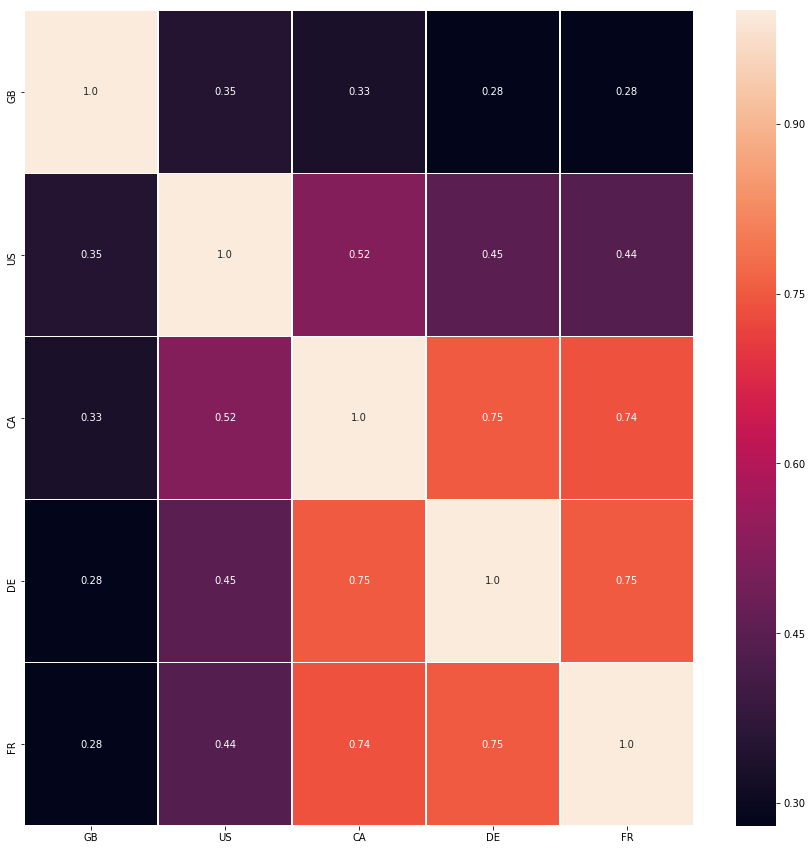

In [23]:
countries = ['GB', 'US', 'CA', 'DE', 'FR'] 
corr_matrix = round(corr_list[countries].corr(),2)

fig, ax = plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt="", linewidths=.5, ax=ax)

# making the colorbar on the side
cbar_min = corr_matrix.min().min()
cbar_max = corr_matrix.max().max()

# making the labels
labels = ['']
for column in countries:
    labels.append(column)
    
#corr_matrix

In [25]:
publish_to_trend = {}
my_df_first = consolidated_df_full.reset_index().drop_duplicates('video_id',keep ='first').set_index('video_id')
diff_first = (my_df_first['trending_date']).astype('datetime64[ns]')-my_df_first['publish_date'].astype('datetime64[ns]')

diff_first = diff_first.reset_index()
diff_first.columns = ['video_id','publish_to_trend']

for i, row in diff_first.iterrows():
    publish_to_trend[row['video_id']] = row['publish_to_trend'].days

my_df_last = consolidated_df
diff_last = consolidated_df['trending_date'].astype('datetime64[ns]')-consolidated_df['publish_date'].astype('datetime64[ns]')
diff_last = diff_last.reset_index()
diff_last.columns = ['video_id','publish_to_trend_last']
consolidated_df = consolidated_df.reset_index()
consolidated_df.insert(4,'publish_to_trend_last', diff_last['publish_to_trend_last'].astype('timedelta64[D]').astype(int))
consolidated_df.insert(4, 'publish_to_trend', consolidated_df['video_id'].map(publish_to_trend))
consolidated_df.insert(4, 'trend_duration', 0)
consolidated_df['trend_duration'] = (consolidated_df['publish_to_trend_last']-consolidated_df['publish_to_trend'])+1
consolidated_df.set_index('video_id')[['publish_to_trend','trend_duration']].sort_values('trend_duration',ascending=False).head()

,publish_to_trend,trend_duration
video_id,,
NooW_RbfdWI,1,38
BhIEIO0vaBE,1,38
2z3EUY1aXdY,0,38
_I_D_8Z4sJE,0,37
LPTlvQ1Zet0,1,37


Text(0.5,1,'Correlation between Days from Publish v/s Trend and Trending Duration')

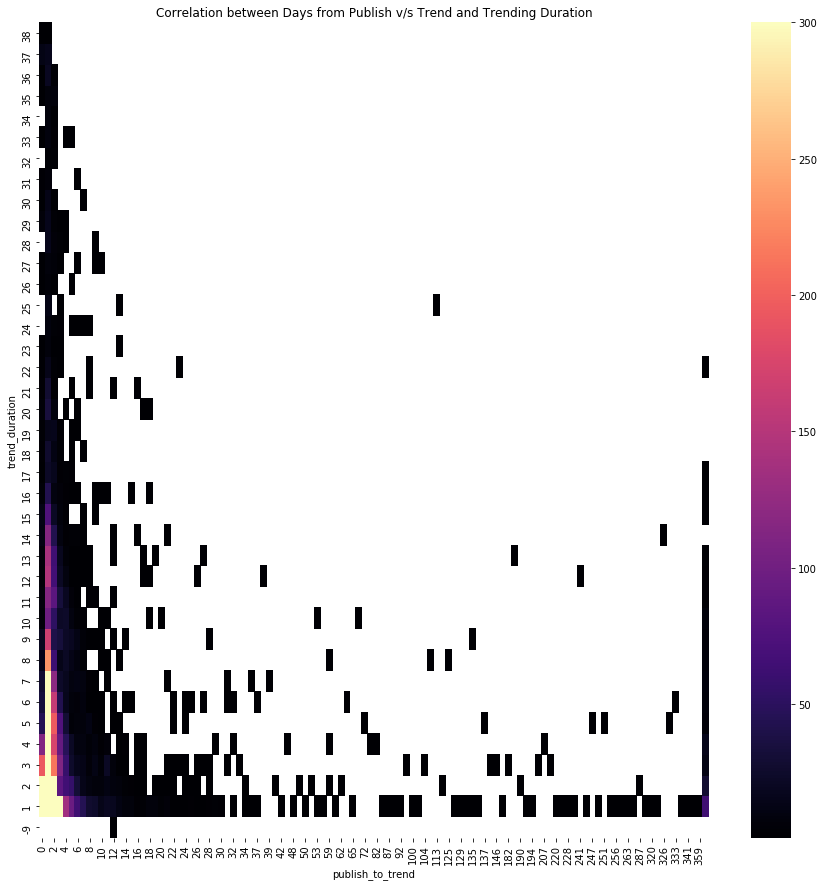

In [26]:
consolidated_df['publish_to_trend'] = consolidated_df['publish_to_trend'].clip(upper=365)
cat_trend_duration= consolidated_df.groupby(['trend_duration','publish_to_trend']).count()['video_id'].unstack().clip(upper=300)
plt.figure(figsize=(15,15))
ax = sns.heatmap(cat_trend_duration, cmap='magma')
ax.invert_yaxis()
plt.title("Correlation between Days from Publish v/s Trend and Trending Duration")

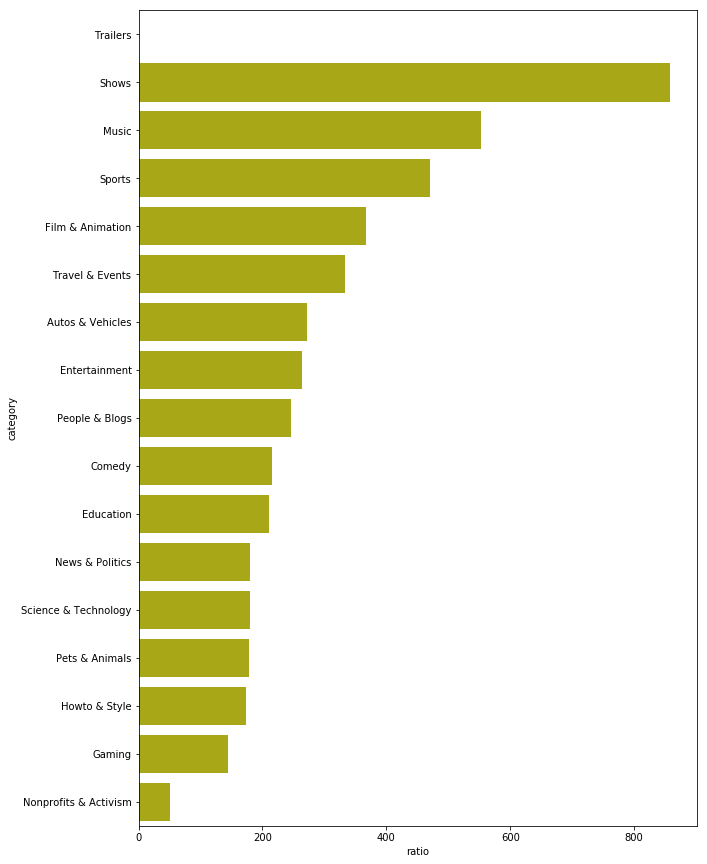

In [16]:
views_comment_ratio = consolidated_df.groupby('category')['views'].agg('sum') / consolidated_df.groupby('category')['comment_count'].agg('sum')
views_comment_ratio = views_comment_ratio.sort_values(ascending=False).reset_index()
views_comment_ratio.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=views_comment_ratio,
            label="Views-Comments Ratio", color="y")

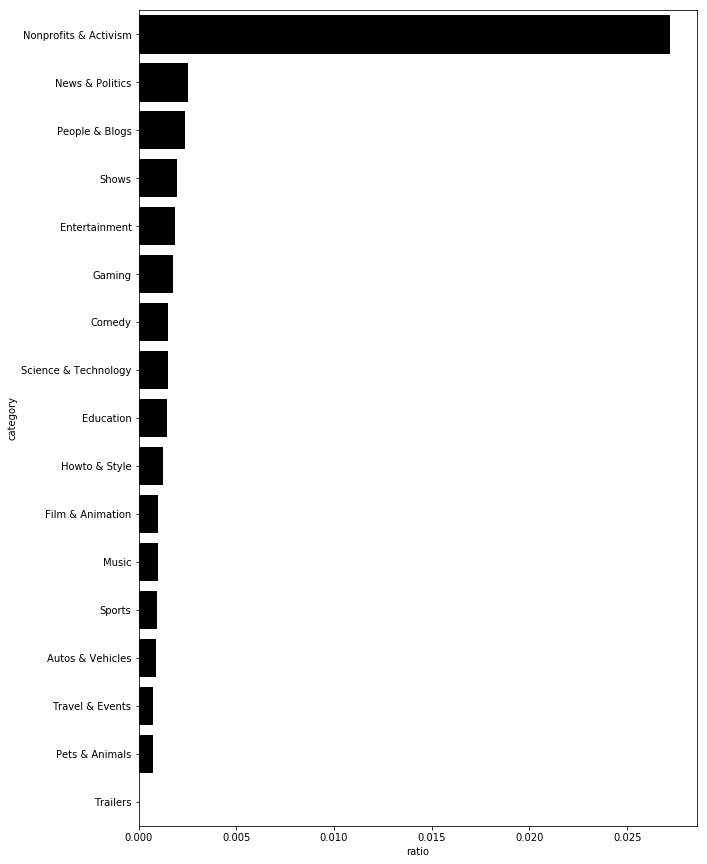

In [17]:
view_dislike_ratio = consolidated_df.groupby('category')['dislikes'].agg('sum') / consolidated_df.groupby('category')['views'].agg('sum')
view_dislike_ratio = view_dislike_ratio.sort_values(ascending=False).reset_index()
view_dislike_ratio.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=view_dislike_ratio,
            label="Views-Dislikes Ratio", color="k")

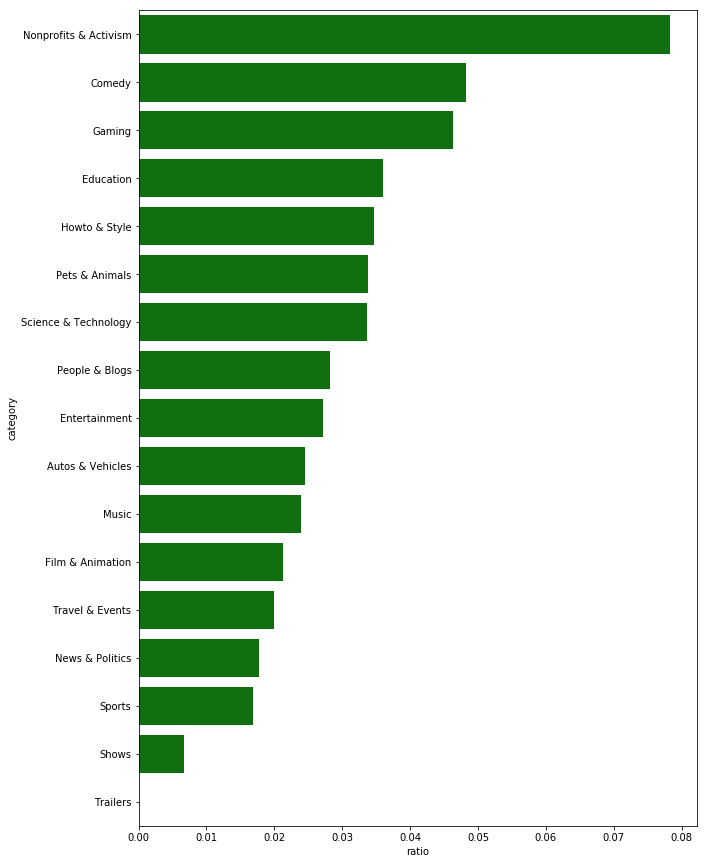

In [18]:
view_like_ratio = consolidated_df.groupby('category')['likes'].agg('sum') / consolidated_df.groupby('category')['views'].agg('sum')
view_like_ratio = view_like_ratio.sort_values(ascending=False).reset_index()
view_like_ratio.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=view_like_ratio,
            label="Views-Likes Ratio", color="g")

Text(0.5,1,'Polarity of Categories in Youtube videos')

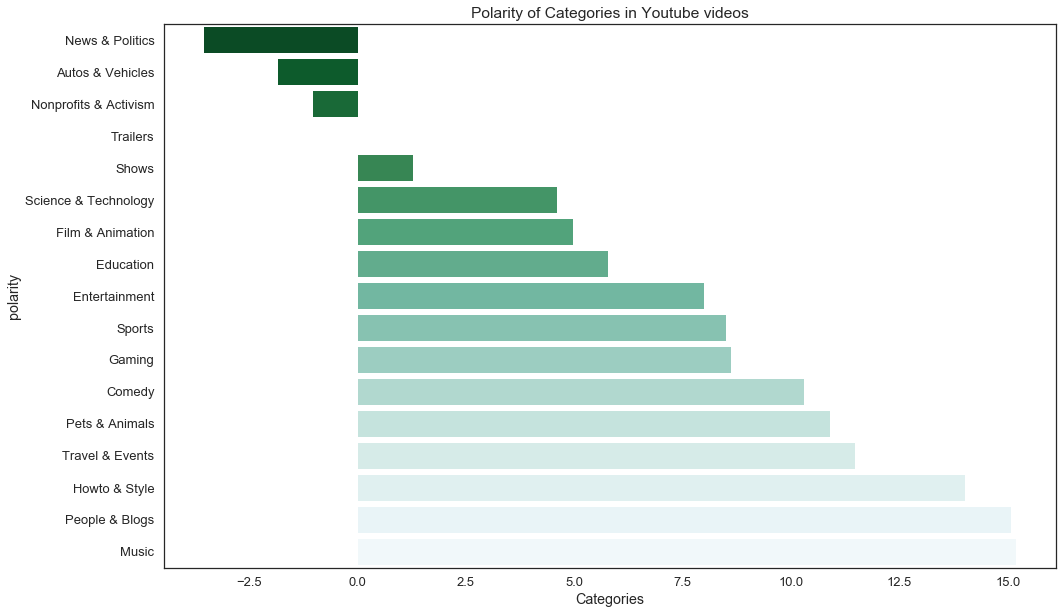

In [19]:
MAX_N = 1000

en_stopwords = list(stopwords.words('english'))
de_stopwords = list(stopwords.words('german'))   
fr_stopwords = list(stopwords.words('french'))   
en_stopwords.extend(de_stopwords)
en_stopwords.extend(fr_stopwords)

polarities = list()

for cate in category_list:
    tags_word = consolidated_df[consolidated_df['category']==cate]['tags'].str.lower().str.cat(sep=' ')

    tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
    word_tokens = word_tokenize(tags_word)
    filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]


    cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]      
    
# Calculate frequency distribution
    word_dist = nltk.FreqDist(cleaned_data_title)
    hnhk = pd.DataFrame(word_dist.most_common(MAX_N),
                    columns=['Word', 'Frequency'])

    compound = .0
    for word in hnhk['Word'].head(MAX_N):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']

    polarities.append(compound)

category_list = pd.DataFrame(category_list)
polarities = pd.DataFrame(polarities)
tags_sentiment = pd.concat([category_list,polarities],axis=1)
tags_sentiment.columns = ['category','polarity']
tags_sentiment=tags_sentiment.sort_values('polarity').reset_index()

plt.figure(figsize=(16,10))
sns.set(style="white",context="talk")
ax = sns.barplot(x=tags_sentiment['polarity'],y=tags_sentiment['category'], data=tags_sentiment,orient='h',palette="BuGn_r")
plt.xlabel("Categories")
plt.ylabel("polarity")
plt.title("Polarity of Categories in Youtube videos")